# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image, includes:
- Estimate relative depth from single images using GPU
- Recover scale using dense geometrical constrains module
- Save disparity images and absolute depth `.npy` file

In [1]:
from __future__ import absolute_import, division, print_function

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from layers import disp_to_depth, ScaleRecovery

## Setting up network and loading weights

In [2]:
model_path = "models"

encoder_path = os.path.join(model_path, "encoder.pth")
depth_decoder_path = os.path.join(model_path, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path)
depth_decoder.load_state_dict(loaded_dict)

encoder.cuda()
encoder.eval()
depth_decoder.cuda()
depth_decoder.eval()

DepthDecoder(
  (decoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv

## Loading the test image and preprocessing

In [3]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0).cuda()

## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)
relative_disp, _ = disp_to_depth(outputs[("disp", 0)], 0.1, 100)
relative_disp_resized = torch.nn.functional.interpolate(
    relative_disp, (original_height, original_width), mode="bilinear", align_corners=False)

## Scale recovery using dense geometrical constrains module

In [5]:
cam_height = torch.tensor([1.65]).cuda()

K = np.array([[0.58, 0, 0.5, 0],
              [0, 1.92, 0.5, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]], dtype=np.float32)
tensor_K = K.copy()
tensor_K[0, :] *= original_width
tensor_K[1, :] *= original_height
tensor_K = torch.from_numpy(tensor_K).unsqueeze(0).cuda()

scale_recovery = ScaleRecovery(1, original_height, original_width).cuda()

relative_depth = 1 / relative_disp_resized
relative_depth = relative_depth.cuda()
scale = scale_recovery(relative_depth, tensor_K, cam_height)
absolute_depth = relative_depth * scale


## Plotting and saving

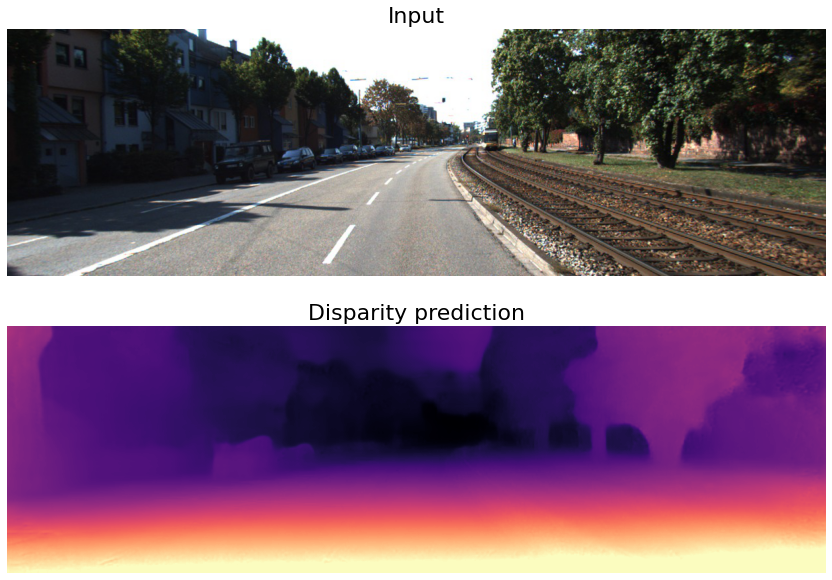

In [8]:

# Saving colormapped depth image
relative_disp_resized_np = relative_disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(relative_disp_resized_np, 95)

plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(relative_disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off')

# Saving absolute depth `.npy` file
absolute_depth_np = absolute_depth.squeeze().cpu().numpy()
np.save("assets/depth.npy", absolute_depth_np)